In [1]:
import csv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')


In [2]:
def convert_text_to_csv(input_file, output_csv):
    # Read and process the text file
    with open(input_file, 'r', encoding='utf-16') as f:
        lines = [line.strip().split('\t') for line in f.readlines()]

    # Extract headers and data rows
    headers = []
    data_rows = []
    
    for parts in lines:
        cleaned = [part.strip() for part in parts if part.strip()]
        if not cleaned:
            continue
        if cleaned[0] == "Country Name":
            headers = cleaned
        elif cleaned[0] not in ["Data Source", "Last Updated Date"]:
            data_rows.append(cleaned)

    # Write to CSV
    with open(output_csv, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(data_rows)
    
    return headers, data_rows

def extract_kenya_inflation(headers, data_rows):
    # Find Kenya's data
    kenya_row = next((row for row in data_rows if row[0] == "Kenya"), None)
    if not kenya_row:
        return None

    # Create Year-Inflation Rate pairs
    inflation_data = []
    for idx, header in enumerate(headers[4:], 4):  # Skip first 4 metadata columns
        if 1980 <= int(header) <= 2023:
            try:
                value = kenya_row[idx] if kenya_row[idx] else "N/A"
                inflation_data.append({
                    "Year": header,
                    "Inflation Rate": value
                })
            except IndexError:
                inflation_data.append({
                    "Year": header,
                    "Inflation Rate": "N/A"
                })
    
    return inflation_data


input_file = "time_series_data.txt"
output_csv = "economic_data.csv"

# Convert text file to CSV
headers, data_rows = convert_text_to_csv(input_file, output_csv)

# Extract Kenya's data for 2014-2023
kenya_values = extract_kenya_inflation(headers, data_rows)

inflation_df = pd.DataFrame(kenya_values)
inflation_df.to_csv(r'Kenya_inflation_data.csv', index = False)

In [3]:
inflation_df['Year'] = pd.to_datetime(inflation_df['Year'], format='%Y')
inflation_df.head()

,Year,Inflation Rate
0,1980-01-01,13.85818146
1,1981-01-01,11.60305344
2,1982-01-01,20.66671467
3,1983-01-01,11.39778274
4,1984-01-01,10.28409821


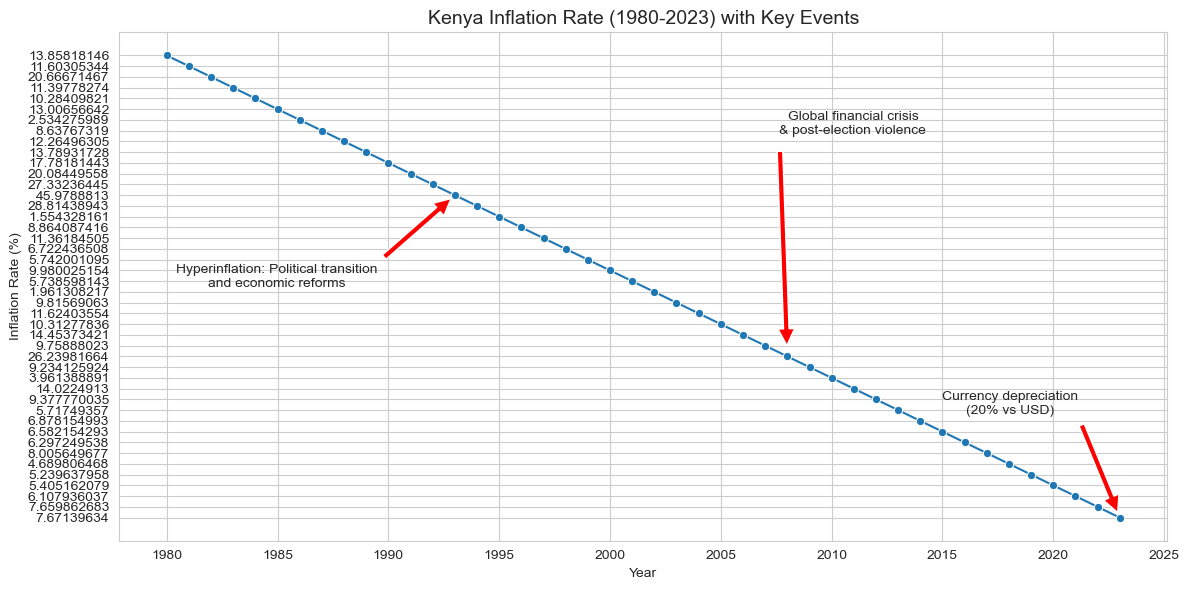

In [4]:
# Visualization 1: Annotated Line Chart with Event Markers
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.lineplot(x='Year', y='Inflation Rate', data=inflation_df, marker='o', color='#1f77b4')

# Annotate key events
events = {
    '1993': ('Hyperinflation: Political transition\nand economic reforms', (0.15, 0.5)),
    '2008': ('Global financial crisis\n& post-election violence', (0.7, 0.8)),
    '2023': ('Currency depreciation\n(20% vs USD)', (0.85, 0.25))
}

for year, (text, xy) in events.items():
    y_value = inflation_df[inflation_df['Year'].dt.year == int(year)]['Inflation Rate'].values[0]
    ax.annotate(text,
                xy=(pd.to_datetime(year), y_value),
                xytext=xy,
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', shrink=0.05),
                ha='center')

plt.title('Kenya Inflation Rate (1980-2023) with Key Events', size=14)
plt.ylabel('Inflation Rate (%)')
plt.tight_layout()
plt.show()

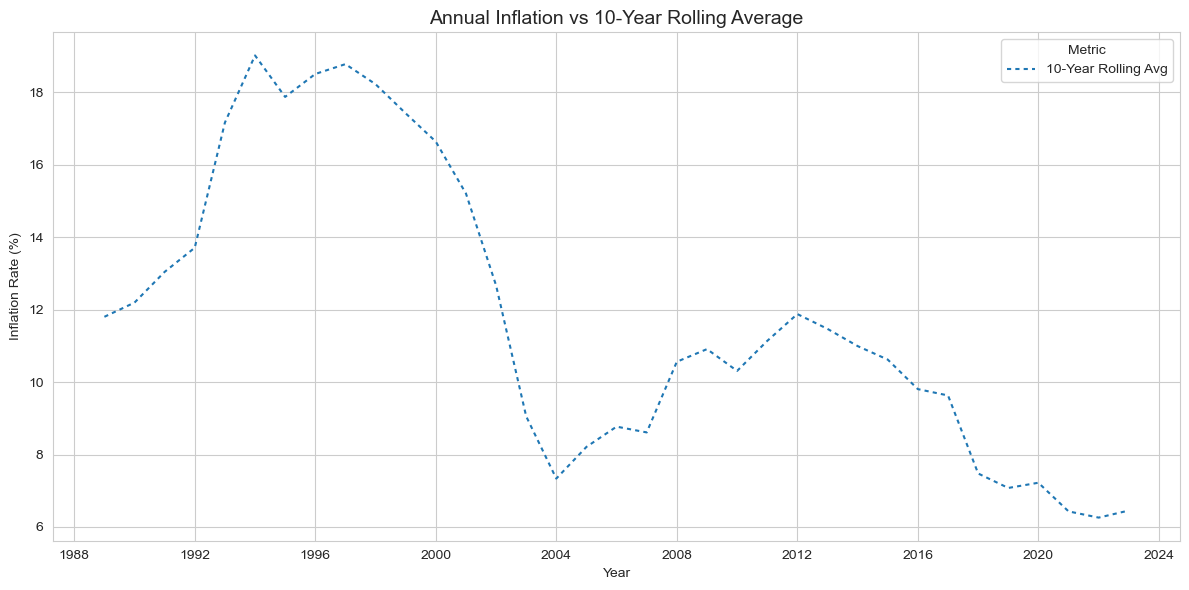

In [5]:
# Visualization 2: Rolling Average vs Annual Rates
plt.figure(figsize=(12, 6))
inflation_df.set_index('Year', inplace=True)
inflation_df['10-Year Rolling Avg'] = inflation_df['Inflation Rate'].rolling(window=10).mean()

sns.lineplot(data=inflation_df[['Inflation Rate', '10-Year Rolling Avg']], 
            dashes={'Inflation Rate': '', '10-Year Rolling Avg': (2, 2)},
            palette=['#1f77b4', '#ff7f0e'])

plt.title('Annual Inflation vs 10-Year Rolling Average', size=14)
plt.ylabel('Inflation Rate (%)')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [6]:
# Test stationarity of the original series
result = adfuller(inflation_df['Inflation Rate'])
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')

ADF Statistic: -3.5705516990036843, p-value: 0.0063496252477497185


In [7]:
# Convert column to numeric
inflation_df['Inflation Rate'] = pd.to_numeric(inflation_df['Inflation Rate'], errors='coerce')

# Drop rows with NaN (if needed)
inflation_df = inflation_df.dropna(subset=['Inflation Rate'])

# Check stationarity
diff = inflation_df['Inflation Rate'].diff().dropna()
result_diff = adfuller(diff)
print(f'ADF Statistic (d=1): {result_diff[0]}, p-value: {result_diff[1]}')

ADF Statistic (d=1): -7.170350319116845, p-value: 2.815107386444047e-10


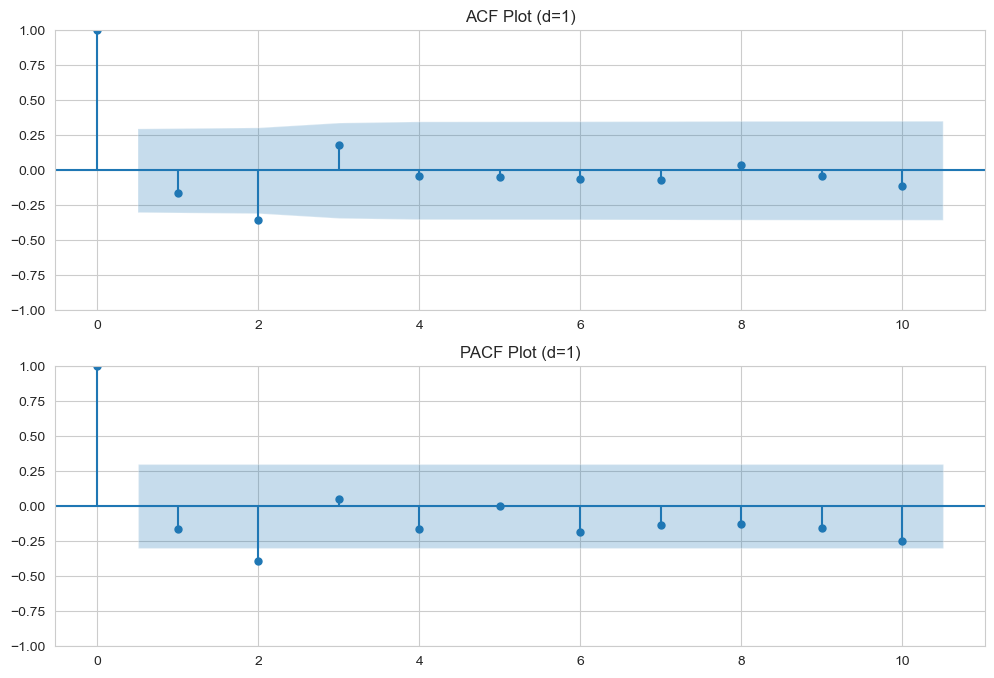

In [8]:
# Plot ACF and PACF for differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(diff, lags=10, ax=ax1, title='ACF Plot (d=1)')
plot_pacf(diff, lags=10, ax=ax2, method='ywm', title='PACF Plot (d=1)')
plt.show()

In [9]:
# Test wider ranges for p and q
p = range(0, 4)  # AR terms: 0-3
q = range(0, 4)  # MA terms: 0-3
d = 1            # Differencing order

best_aic = float('inf')
best_order = None

for order in itertools.product(p, [d], q):
    try:
        model = ARIMA(inflation_df['Inflation Rate'], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print(f'Optimal Order: {best_order} (AIC: {best_aic})')

Optimal Order: (0, 1, 2) (AIC: 295.53185671485636)


In [10]:
# Model 1: ARIMA(0,1,2)
model_012 = ARIMA(inflation_df['Inflation Rate'], order=(0,1,2))
results_012 = model_012.fit()

# Model 2: ARIMA(2,1,1)
model_211 = ARIMA(inflation_df['Inflation Rate'], order=(2,1,1))
results_211 = model_211.fit()

print(f'ARIMA(0,1,2) AIC: {results_012.aic}')
print(f'ARIMA(2,1,1) AIC: {results_211.aic}')

ARIMA(0,1,2) AIC: 295.53185671485636
ARIMA(2,1,1) AIC: 300.6915118548191


In [11]:
# Ljung-Box Test for Residual Autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals_012 = results_012.resid
lb_test_012 = acorr_ljungbox(residuals_012, lags=10)

residuals_211 = results_211.resid
lb_test_211 = acorr_ljungbox(residuals_211, lags=10)

print("ARIMA(0,1,2) Residual p-values:\n", lb_test_012.lb_pvalue)
print("\nARIMA(2,1,1) Residual p-values:\n", lb_test_211.lb_pvalue)

ARIMA(0,1,2) Residual p-values:
 1     0.680117
2     0.678361
3     0.817130
4     0.892405
5     0.925439
6     0.762305
7     0.763207
8     0.795134
9     0.848118
10    0.869809
Name: lb_pvalue, dtype: float64

ARIMA(2,1,1) Residual p-values:
 1     0.743108
2     0.940655
3     0.803655
4     0.879356
5     0.938603
6     0.780037
7     0.849885
8     0.897640
9     0.939772
10    0.966169
Name: lb_pvalue, dtype: float64


In [12]:
# Fit ARIMA(0,1,2)
model_arima = ARIMA(inflation_df['Inflation Rate'], order=(0,1,2))
results_arima = model_arima.fit()

# Forecast 5 years
forecast_arima = results_arima.get_forecast(steps=5)
forecast_index = pd.date_range(start='2024', periods=5, freq='YS')

arima_forecast_df = pd.DataFrame({
    'Year': forecast_index.year,
    'Inflation Rate (ARIMA)': forecast_arima.predicted_mean,
    'Lower CI (ARIMA)': forecast_arima.conf_int().iloc[:, 0],
    'Upper CI (ARIMA)': forecast_arima.conf_int().iloc[:, 1]
})

In [14]:
# Prepare Prophet data
prophet_df = inflation_df.reset_index()[['Year', 'Inflation Rate']]
prophet_df.columns = ['ds', 'y']  # Rename columns to 'ds' (datetime) and 'y' (value)

# Convert 'ds' to datetime format (no need for .dt.to_timestamp())
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Fit Prophet model
model_prophet = Prophet(yearly_seasonality=False, changepoint_prior_scale=0.1)
model_prophet.fit(prophet_df)

# Forecast 5 years
future = model_prophet.make_future_dataframe(periods=5, freq='Y')
forecast_prophet = model_prophet.predict(future)

# Extract forecast results
prophet_forecast_df = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)
prophet_forecast_df['Year'] = prophet_forecast_df['ds'].dt.year

23:34:32 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing


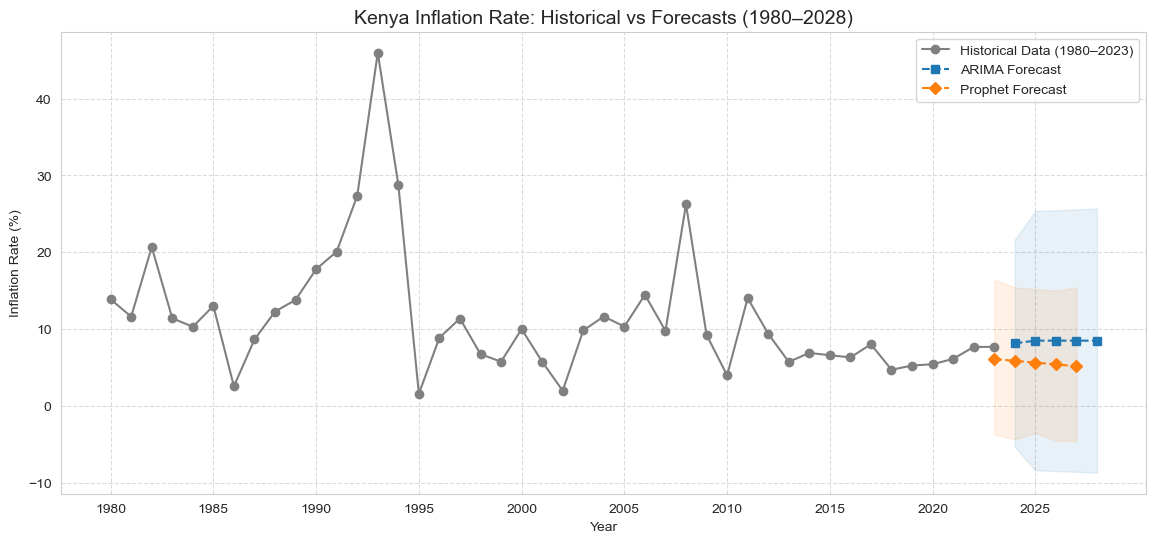

In [16]:
plt.figure(figsize=(14, 6))

# Historical data (1980–2023)
plt.plot(inflation_df.index.year, inflation_df['Inflation Rate'], 
         label='Historical Data (1980–2023)', color='gray', marker='o')

# ARIMA forecast (2024–2028)
plt.plot(arima_forecast_df['Year'], arima_forecast_df['Inflation Rate (ARIMA)'], 
         label='ARIMA Forecast', color='#1f77b4', linestyle='--', marker='s')
plt.fill_between(arima_forecast_df['Year'], 
                 arima_forecast_df['Lower CI (ARIMA)'], 
                 arima_forecast_df['Upper CI (ARIMA)'], 
                 color='#1f77b4', alpha=0.1)

# Prophet forecast (2024–2028)
plt.plot(prophet_forecast_df['Year'], prophet_forecast_df['yhat'], 
         label='Prophet Forecast', color='#ff7f0e', linestyle='--', marker='D')
plt.fill_between(prophet_forecast_df['Year'], 
                 prophet_forecast_df['yhat_lower'], 
                 prophet_forecast_df['yhat_upper'], 
                 color='#ff7f0e', alpha=0.1)

# Formatting
plt.title('Kenya Inflation Rate: Historical vs Forecasts (1980–2028)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.xticks(range(1980, 2029, 5))  # 5-year intervals
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [17]:
arima_forecast_df.to_csv(r"arima_forecast.csv", index = False)

In [18]:
prophet_forecast_df.to_csv(r"prophet_forecast.csv", index = False)